In [105]:
using Plots
using LaTeXStrings
using SparseArrays
using BlockDiagonals
using Arpack
using BenchmarkTools

In [106]:
# Muller's method
function muller(f, x0, x1, x2, tol=1e-4, max_iter=500)
    for _ in 1:max_iter
        f0 = f(x0)
        f1 = f(x1)
        f2 = f(x2)
        
        h0 = x1 - x0
        h1 = x2 - x1
        δ0 = (f1 - f0) / h0
        δ1 = (f2 - f1) / h1
        a = (δ1 - δ0) / (h1 + h0)
        b = a * h1 + δ1
        c = f2
        
        rad = sqrt(b^2 - 4 * a * c)
        if abs(b - rad) < abs(b + rad)
            den = b + rad
        else
            den = b - rad
        end
        
        dx = -2 * c / den
        x3 = x2 + dx
        
        if abs(dx) < tol
            return x3
        end
        
        x0, x1, x2 = x1, x2, x3
    end
    error("The method did not converge")
end

muller (generic function with 3 methods)

In [107]:
# Define functions for the current sheet F, F', F'' 
F(x) = tanh(x)
dF(x) = sech(x)^2
ddF(x) = -2 * tanh(x) * sech(x)^2

ddF (generic function with 1 method)

In [108]:
function grid_spacing(domain::Tuple, n::Int, λ::Rational) 
    # λ ∈ [-1, 1]
    a, b = domain
    # compute spacing on domain: (0, 1)
    u = [((j) / (n-1)) + (λ / (2*π)) * sin(2*π*(j) / (n-1)) for j in 0:n-1]
    # now apply a linear tranformation to go from (0, 1) -> (a, b)
    return [a + (b - a) * k for k in u]
end

grid_spacing (generic function with 1 method)

In [109]:
function createA(nodes, γ, params)
    S = params[1]
    k = params[2]
    
    # define block
    blocks = []

    for i in nodes
        A11 = -(S * γ + k^2)
        A12 = S .* γ .* F(i)
        A21 = (k^2 / γ^2) .* (F(i) .* S .* γ .- ddF(i))
        A22 = -k^2 .* (1 + (S / γ) .* F(i)^2)

        push!(blocks, [A11 A12; A21 A22])
    end

    # place the blocks to the diagonals of A 
    A = BlockDiagonal([blocks[j] for j = 1:length(nodes)])
    # make first and last blocks zero to satisfy the BCs
    A[1:2, 1:2] .= 0.0
    A[end-2+1:end, end-2+1:end] .= 0.0

    return A
end

createA (generic function with 1 method)

In [110]:
# Function to compute finite difference weights
function stencil(x::Vector{<:Real}, x₀::Real, m::Integer, p::Integer=2)
    ℓ = 0:p
    A = @. (x' - x₀)^ℓ / factorial(ℓ)
    b = ℓ .== m
    return A \ b
end

stencil (generic function with 2 methods)

In [111]:
# Function to create a sparse banded differentiation matrix for coupled ODEs
function differentiation_matrix(x::Vector{<:Real}, m::Integer, p::Integer=2)
    n = length(x)
    N = 2*n # Since we have two coupled ODEs
    D = spzeros(N, N)
    if n < 3
        throw(ArgumentError("The vector length must be at least 3 for a tridiagonal matrix"))
    end
    
    # Helper function to insert weights into the differentiation matrix
    function insert_weights!(D, row, stencil_indices, weights)
        for (j, idx) in enumerate(stencil_indices)
            D[row, 2*idx-1] = weights[j]
        end
    end
    
    # Handle the interior points using a central difference
    for i in 2:n-1
        stencil_indices = i-1:i+1
        stencil_x = x[stencil_indices]
        x₀ = x[i]
        weights = stencil(stencil_x, x₀, m, p)
        
        # Insert weights for ψ at row 2*i - 1
        insert_weights!(D, 2*i - 1, stencil_indices, weights)
        
        # Insert staggered weights for ϕ at row 2*i
        for (j, idx) in enumerate(stencil_indices)
            D[2*i, 2*idx] = weights[j]
        end
    end
    
    # Handle the first point using a forward difference
    stencil_indices = 1:p+2
    stencil_x = x[stencil_indices]
    x₀ = x[3]
    weights = stencil(stencil_x, x₀, m, p+2)
    
    # Insert weights for ψ at row 1
    insert_weights!(D, 1, stencil_indices, weights)
    
    # Insert staggered weights for ϕ at row 2
    for (j, idx) in enumerate(stencil_indices)
        D[2, 2*idx] = weights[j]
    end
    
    # Handle the last point using a backward difference
    stencil_indices = n-(p+1):n
    stencil_x = x[stencil_indices]
    x₀ = x[n]
    weights = stencil(stencil_x, x₀, m, p+2)
    
    # Insert weights for ψ at row 2*n - 1
    insert_weights!(D, 2*n - 1, stencil_indices, weights)
    
    # Insert staggered weights for ϕ at row 2*n
    for (j, idx) in enumerate(stencil_indices)
        D[2*n, 2*idx] = weights[j]
    end
    
    return D
end

differentiation_matrix (generic function with 2 methods)

In [112]:
function generate_matrices(x, γ, params)
    # create and slice down matrices to perform matrix shooting
    A = createA(x, γ, params)[3:end-1, 3:end-1]
    Dxx = differentiation_matrix(x, 2)[3:end-1, 3:end-1]

    U = Dxx .+ A # create U by adding diff. matrix and system of eqns
    V = convert(Vector, -U[:, 1]) # V is the negative of the ψ₂ column

    # Now remove the ψ₂ column of matrix U
    # U_rem = U[:, 2:end]
    
    return U[:, 2:end], V
end

generate_matrices (generic function with 1 method)

In [113]:
function linear_solve(U, V)
    sol = U \ V
    # global ψ = sol[2:2:end]
    # global ϕ = sol[1:2:end-1]
    return sol[end]
end

linear_solve (generic function with 1 method)

In [114]:
function plot_eigfuncs(x, ψ, ϕ)
    # plot the eigenfunctions ψ, ϕ
    theme(:dao::Symbol)

    myplot = scatter(x[2:end-1], real.(ϕ), markershape=:circle, markersize=:2.5, lw=3, label=L"$\phi$")
    myplot = scatter!(x[3:end], real.(ψ),
        markershape=:circle,
        markersize=:2.5,
        lw=3,
        legend=:best,
        label=L"$\psi$",
        title="Single Mode: Matrix Shooting",
        xlabel=L"$x$",
        ylabel=L"$\psi(x), \phi(x)$",
        titlefontsize=20,  # title
        tickfontsize=12,  # ticks
        legendfontsize=10, # legend
        yguidefontsize=15, # guides
        xguidefontsize=15
    )

    # savefig(myplot, "singlemode_tearing_matshoot.png")
    return myplot
end

plot_eigfuncs (generic function with 1 method)

In [115]:
function iteration(γ)
    domain = (-10, 10)
    n = 200
    λ = 2//3
    params = [1000.0, 0.5]
    
    x = grid_spacing(domain, n, λ)

    function get_psi_n(γ)
        U, V = generate_matrices(x, γ, params)
        return linear_solve(U, V)
    end

    γ_best = muller(get_psi_n, γ+0.0002, γ, γ-0.0002)
    U_final, V_final = generate_matrices(x, γ_best, params)

    return γ_best, U_final, V_final, x
end

iteration (generic function with 1 method)

In [116]:
# use best values of gamma from previous, easier iterations for faster runtimes and more accuracy!
γ, U, V, x = iteration(0.01309+1e-5im);

In [119]:
U[1:6, 1:6]

6×6 SparseMatrixCSC{ComplexF64, Int64} with 18 stored entries:
 -13.1594+0.0149229im  …           ⋅                    ⋅    
 -19069.4-21.5437im                ⋅                    ⋅    
          ⋅                        ⋅                    ⋅    
  35.6883+0.0im            35.7168+0.0im                ⋅    
          ⋅               -13.1594+0.0149229im  35.7952+0.0im
          ⋅            …  -19069.6-21.5437im            ⋅    

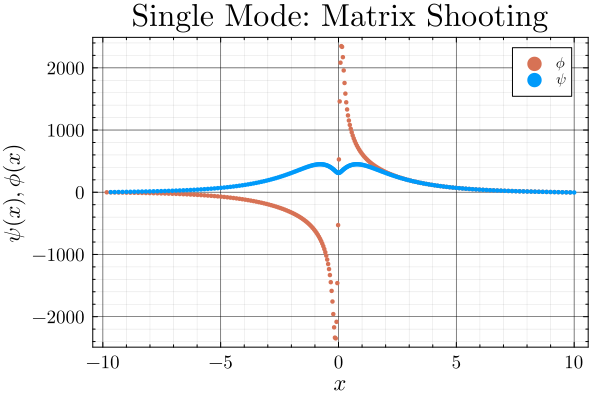

In [117]:
sol = U \ V
ψ = sol[2:2:end]
ϕ = sol[1:2:end-1]

plot_eigfuncs(x, ψ, ϕ)

In [118]:
γ

0.013159402210324583 - 1.4922903197383844e-5im